<a href="https://colab.research.google.com/github/vaishakrajeev/MG_Scheduling/blob/main/MicroGrid_Environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"> Microgrid Environment Structure</h1> 

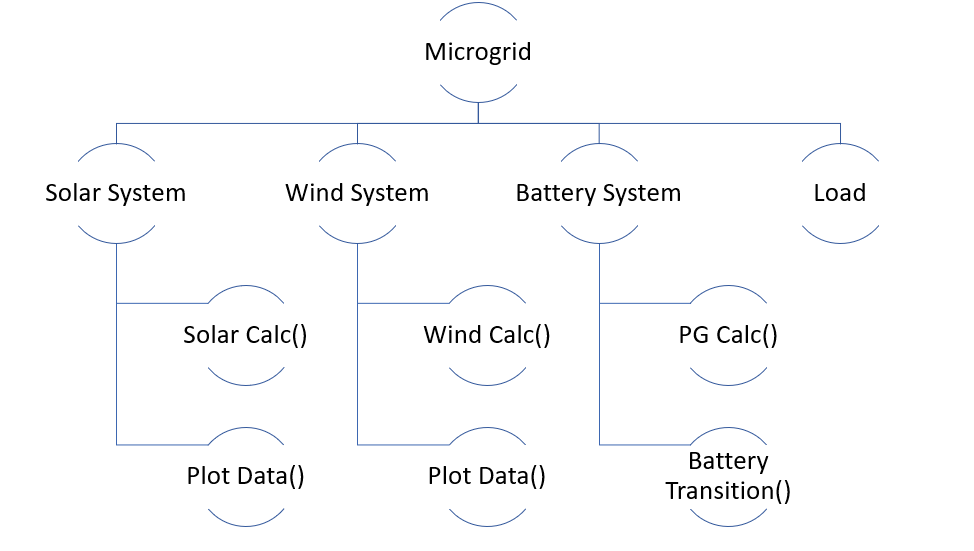!

#### The microgrid environment is sub divided into a solar energy system, wind energy system, Battery pack and the load.


All the needed libraries are imported in the following cells

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import pickle #for storing q values
import gym
from gym import Env
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Solar Energy System

In [28]:
class SolarSystem:
    def __init__(self,A=34,seff=0.16,MaxSP=5,NSP=7): #Constructor, which initialises solar system's parameters.
        #Solar parameters
        self.A = A           #Area of panel in meter square
        self.seff = seff     #Solar panel efficiency in %
        self.MaxSP = MaxSP   #Maximum solar power in KW
        self.NSP = NSP       #Number of Solar panels
        self.Solar_Power_Data = None
        
    def Solar_Calc(self,Data,days):  #Performs the solar calculations for the Entire data imported
        Solar_Power = np.zeros((days,24))
        for day in range(days):
            for hour in range(24):
                SI = Data[day][hour]
                Solar_Power[day][hour] = self.NSP*self.seff*self.A*SI/1000
        self.Solar_Power_Data = Solar_Power
    
    def Print_Data(self):   #Prints the Solar power data obtained after calculation
        print(self.Solar_Power_Data)
    
    def retData(self,day,hour): #Returns the Solar power data for the day and hour passed as parameter.

        return self.Solar_Power_Data[day][hour]
    
    def Plot_Data(self,nd):    #Plots the Solar power data for the day passed as parameter.
        plt.plot(self.Solar_Power_Data[nd], label='PV{}'.format(nd))
        plt.xlabel('Hour')
        plt.ylabel('Power')
        plt.title('Solar Energy Variation in {}th day'.format(nd))
        plt.legend()
        return(plt.show())
   

## Wind Energy System

In [29]:
class WindSystem:
    def __init__(self,vc=3,vf=25,vr=12,MaxWP=5,NWP=8):#Constructor, which initialises wind system's parameters.
        #Wind Parameters
        self.vc = vc       #Cut-in velocity in m/s
        self.vf = vf       #Cut-off velocity in m/s
        self.vr = vr       #Rated speed in m/s
        self.MaxWP = MaxWP #Maximum wind power in KW
        self.NWP = NWP     #Number of wind turbines
        self.Wind_Power_Data = None
    
    def Wind_Calc(self,Data,days):#Performs the wind calculations for the Entire data imported
        Wind_Power = np.zeros((days,24))
        for day in range(days):
            for hour in range(24):
                v = Data[day][hour]
                if(self.vf<=v or self.vc>=v):
                    pw = 0
                if(self.vc<=v and v<=self.vr):
                    pw = (self.MaxWP*(pow(v,3)-pow(self.vc,3))/(pow(self.vr,3)-pow(self.vc,3)))
                if(self.vr<= v and v<=self.vf):
                    pw = self.MaxWP
                Wind_Power[day][hour] = pw*self.NWP
        self.Wind_Power_Data = Wind_Power
        
    def Print_Data(self):#Prints the wind power data obtained after calculation
        print(self.Wind_Power_Data)
    def retData(self,day,hour):#Returns the wind power data for the day and hour passed as parameter.

        return self.Wind_Power_Data[day][hour]
    
    def Plot_Data(self,nd):#Plots the wind power data for the day passed as parameter.
        plt.plot(self.Wind_Power_Data[nd], label='Wind{}'.format(nd))
        plt.xlabel('Hour')
        plt.ylabel('Power')
        plt.title('Wind Energy Variation in {}th day'.format(nd))
        plt.legend()
        return(plt.show())

## Battery

In [30]:
class Battery:
    def __init__(self,BLmax = 33,BLmin = 7.2,BLv = 18,Crate = 1,Drate = -1):
        #Battery parameters
        self.BLmax = BLmax         #Maximum energy level in KWh
        self.BLmin = BLmin         #Minimum energy level in KWh
        self.BLv = BLv             #Initial energy level in KWh
        self.Crate = Crate         #Maximum charging rate in KWh
        self.Drate = Drate         #Maximum discharging rate in KWh
        self.CurrentBL = BLv       # Initial energy level in KWh
        
    def PG_Calc(self,load,solar,wind,action): #Net Energy Calculation, which determines import/Export.
        if action==2:
            action=-1
            u = action*self.Drate
            PG = load-solar-wind + u
        else:
            u = action*self.Crate
            PG = load-solar-wind + u
        return PG
    
    
    def Battery_Transition(self,BatteryCMDsignal=0,Deltat=1):#Battery levels variation through the action.
        #BatteryCMDsignal-0 Idle
        #BatteryCMDSignal-1 Charge
        #BatteryCMDSignal-2 Discharge
        if(BatteryCMDsignal ==1):
            if(self.CurrentBL>=self.BLmax):
                
                return -1
            else:
                self.CurrentBL=self.CurrentBL + Deltat*self.Crate
                return 0
        elif(BatteryCMDsignal == 2):
            if(self.CurrentBL<=self.BLmin):
                
                return -1
            else:
                self.CurrentBL=self.CurrentBL + Deltat*self.Drate
                return 0
        elif(BatteryCMDsignal == 0):
            self.CurrentBL = self.CurrentBL
            return 0
        else:
            return -1
        
    def ret_CurrentBL(self):#Returns the current battery level
        return self.CurrentBL
                
            

<h2 align="center"> Structure of an Openai gym complying environment</h2> 

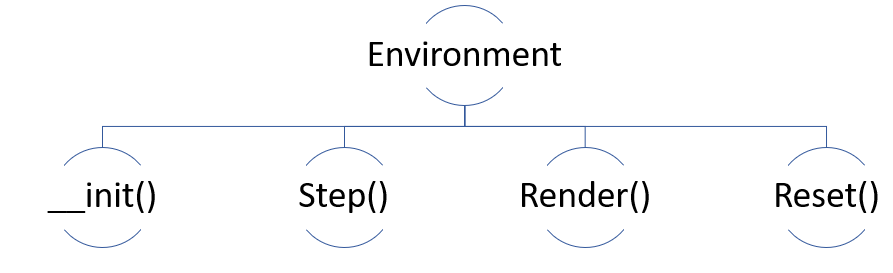

<h2 align="center"> Microgrid Environment</h2> 

In [31]:
class MicroGrid(gym.Env):
    def __init__(self,train=1):#Constructor, which initialises Microgrid's parameters 
        #Train - 1->Training
        #Train - 0-> Testing 
        self.s = SolarSystem(A=34,seff=0.16,MaxSP=5,NSP=7)
        self.w = WindSystem(vc=3,vf=25,vr=12,MaxWP=5,NWP=8)
        self.b = Battery(BLmax=33,BLmin = 7.2,BLv = 18,Crate = 1,Drate = -1)
        self.l,self.nd = self.Read_Data(self,train)
        self.Price = [3, 3, 4,5,6,7,6,5,7,8,5,8,5,3,12,12,12,11,10,9,8,5,4,3]
        self.state = []
        self.state.append(18)
        self.state.append(0)
        self.day=0
        self.highpenality=-150
        self.cumcost = 0
        self.action_space = gym.spaces.Discrete(3)
        self.observation_space = gym.spaces.MultiDiscrete([36,24])

    def step(self, action): #Imparts the change in microgrid environment, when the action is taken
        reward=0
        permit = self.b.Battery_Transition(BatteryCMDsignal=action,Deltat=1)
        self.state[0]=self.b.CurrentBL
        if(permit==-1):
            reward = self.highpenality
            PG = self.b.PG_Calc(self.l[self.day][self.state[1]],self.s.retData(self.day,self.state[1]),self.w.retData(self.day,self.state[1]) ,action)
            self.cumcost +=-PG*self.Price[self.state[1]]
        else:
            PG = self.b.PG_Calc(self.l[self.day][self.state[1]],self.s.retData(self.day,self.state[1]),self.w.retData(self.day,self.state[1]) ,action)
            reward=-PG*self.Price[self.state[1]]
            self.cumcost += reward 
        self.state[1] += 1#self.state[1] increments by 1 hour
        if self.state[1]>=24:
            done = True
        else:
            done= False
        info = {}
        return self.state,reward, done, info
    
    def render(self):
        pass
    
    def reset(self):
        self.state[1] = 0  #self.state[1]
        if self.day <1827:
            self.day+=1
        return self.state
    
    def Read_Data(self,nd=1827,train=1): #Reads the data from the dataset
        #Train - 1->Training
        #Train - 0-> Testing
        if train==1:
            data = pd.read_excel (r'gdrive/My Drive/Brazil1ym.xlsx',sheet_name= 'Basel_4y')
            df = pd.DataFrame(data, columns= ['Load', 'SI','V'])
            
            nd = 1827
        elif train==0:#Test
            data = pd.read_excel (r'gdrive/My Drive/Brazil1ym.xlsx',sheet_name= 'Basel_31d2')
            df = pd.DataFrame(data, columns= ['Load12', 'SI1','V1'])
            nd = 31
        th=24
        Loaded = df.iloc[:, 0].values
        Loaded = Loaded*20
        print(Loaded)
        Solar = df.iloc[:, 1].values
        Wind = df.iloc[:, 2].values
        Load=np.zeros((nd,th))
        V = np.zeros((nd,th))
        SI = np.zeros((nd,th))
        count = 0
        for day in range(nd):
            for hour in range(th):
                V[day][hour] = Wind[count]
                SI[day][hour] = Solar[count]
                Load[day][hour] = Loaded[count]
                count += 1
        self.s.Solar_Calc(SI,nd)
        self.w.Wind_Calc(V,nd)
        return (Load,nd)

            
    
        

In [32]:
env = MicroGrid()

[21.14 23.42 11.2  ... 33.32 16.26 20.34]
